# Selección de datos de movilidad, dentro del área de estudio
## Cargar paquetes

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # For progress tracking

Variables globales

In [3]:
# Path del Shapefile de Azuay
azuay_shapefile_path = 'shape_data/LIMITE_AZUAY_PROVINCIA/LIMITE_AZUAY_PROVINCIA.shp'
# Path del Shapefile de Cuenca
cuenca_shapefile_path = 'shape_data/LIMITE_CUENCA_CANTON/LIMITE_CUENCA_CANTON.shp'
# Path del Shapefile de Ecuador
ecuador_shapefile_path = 'shape_data/LIMITE_PROVINCIAL_CONALI_CNE_2022/LIMITE_PROVINCIAL_CONALI_CNE_2022.shp'
# Default CRS
default_crs = 'EPSG:4326'

## Cargar shapefile con límites de área de estudio

Asignar el sistema de coordenadas `EPSG:4326` a los shapefiles leídos con Geopandas

### Provincia Azuay

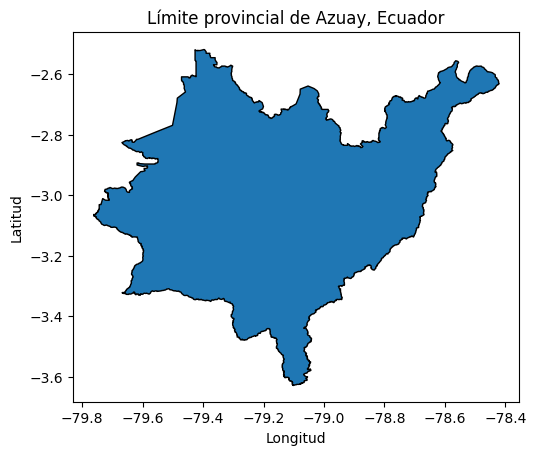

In [8]:
# Leer shapefile en un Geodataframe
gdf_azuay = gpd.read_file(azuay_shapefile_path)

# Establecer el sistema de coordendas
gdf_azuay = gdf_azuay.to_crs(crs=default_crs)

# Visualizar el shapefile
gdf_azuay.plot(edgecolor='black')
plt.title('Límite provincial de Azuay, Ecuador')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

### Cantón Cuenca

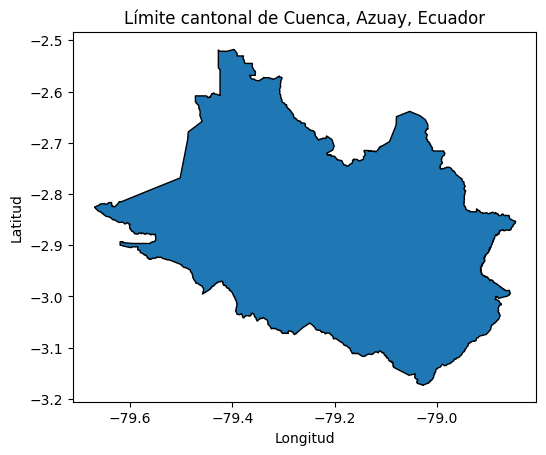

In [7]:
# Leer shapefile en un Geodataframe
gdf_cuenca = gpd.read_file(cuenca_shapefile_path)

# Establecer el sistema de coordendas EPSG:4326
gdf_cuenca = gdf_cuenca.to_crs(crs=default_crs)

# Visualizar el shapefile
gdf_cuenca.plot(edgecolor='black')
plt.title('Límite cantonal de Cuenca, Azuay, Ecuador')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

## Cargar datos **raw** 'Trips' y 'Points'

- El archivo CSV **tripssep2023.csv** contiene datos que resumen los viajes registrados por un usuario. Entre ellos, idetificador de usuario, distancia de viaje, timestamp de llegada y salida, coordeadas (X e Y) del punto de origen y destino del viaje en sistema `EPSG:32717`, entre otros.

- El archivo CSV **puntossept2023.csv** contiene el detalle de cada viaje realizado por el usuario. Entre los campos disponibles se encuentran, identificador del usuario, identificador de dispositivo, coordenadas (latitud y longitud) `EPSG:4326`, entre otros.

Se obtienen los Dataframes `df_trips` y `df_points`.

In [5]:
# Leer CSVs de trips y points
df_trips = pd.read_csv('raw_data/tripssep2023.csv')
df_points = pd.read_csv('raw_data/puntossept2023.csv')

# Visualizar data (head)
print("________ POINTS ________")
print(f"Numero de tuplas en Points: {len(df_points)}\n")
print(df_points.head())

print("________ TRIPS ________")
print(f"Numero de tuplas en Trips: {len(df_trips)}\n")
print(df_trips.head())

/tmp/ipykernel_4000/2221341711.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points = pd.read_csv('raw_data/puntossept2023.csv')


________ POINTS ________
Numero de tuplas en Points: 3370415

         id   company_token                                  uuid  \
0  16911233  bryan.minchala  BDF1BBB0-53D1-4A10-A2CB-A61B9240449C   
1  16911234  bryan.minchala  D5AD12C0-CC1C-4E2E-97BA-F26E3D9CB8BC   
2  16911235  bryan.minchala  E1C0146E-FA6F-403A-AA4C-1BA6F9BD1E4F   
3  16911236  bryan.minchala  B2F00DCF-3871-4FA6-8005-6AC251A25D78   
4  16911237  bryan.minchala  2D2E930E-12DE-4D23-9022-325AEB54F386   

          device_id              device_model  latitude  longitude  accuracy  \
0  iPhone7-2-12-5-7  flutter-iPhone7,2-12.5.7 -2.787665 -78.859393       175   
1  iPhone7-2-12-5-7  flutter-iPhone7,2-12.5.7 -2.787549 -78.859319       175   
2  iPhone7-2-12-5-7  flutter-iPhone7,2-12.5.7 -2.788432 -78.859697       165   
3  iPhone7-2-12-5-7  flutter-iPhone7,2-12.5.7 -2.788600 -78.859895        65   
4  iPhone7-2-12-5-7  flutter-iPhone7,2-12.5.7 -2.788765 -78.859987       160   

   altitude  speed  ...  activity_type  ac

### Ver tipos de dato de Dataframes

In [6]:
# Ver tipos de dato de Points
print(df_points.dtypes)

id                       int64
company_token           object
uuid                    object
device_id               object
device_model            object
latitude               float64
longitude              float64
accuracy                 int64
altitude               float64
speed                  float64
heading                float64
odometer               float64
event                   object
activity_type           object
activity_confidence      int64
battery_level          float64
battery_is_charging       bool
is_moving                 bool
geofence               float64
provider                object
extras                  object
recorded_at             object
created_at              object
dtype: object


In [7]:
# Ver tipos de dato de Trips
print(df_trips.dtypes)

Unnamed: 0           int64
tripid               int64
points               int64
travel_distance    float64
departure           object
arrival             object
travel_time        float64
uid                 object
origin_x           float64
origin_y           float64
destination_x      float64
destination_y      float64
dtype: object


## Tratamiento de datos

Para el Dataframe `df_trips`

### 1. Transformar coordenadas de `EPSG:32717` a `EPSG:4326`

- En el Dataframe `df_trips`. Obtenemos las coordenadas latitud y logitud (EPSG:4326) a partir de las coordenadas X e Y (EPSG:32717) de los puntos de origen y destino de viaje.
- Agregamos las nueva coordenadas en el Dataframe, y lo guardamos como un archivo CSV `transformed_data/tripssep2023_epsg4326.csv`.

In [ ]:
# Crear una geometría a partir de las coordenadas (X, Y) en EPSG:32717 (UTM)
# Origin
geom_trips_origin = [Point(xy) for xy in zip(df_trips['origin_x'], df_trips['origin_y'])]
gdf_trips_origin = gpd.GeoDataFrame(df_trips, geometry=geom_trips_origin, crs="EPSG:32717")
# Destination
geom_trips_dest = [Point(xy) for xy in zip(df_trips['destination_x'], df_trips['destination_y'])]
gdf_trips_dest = gpd.GeoDataFrame(df_trips, geometry=geom_trips_dest, crs="EPSG:32717")

# Transformar geometría a EPSG:4326
# Origin
gdf_trips_origin = gdf_trips_origin.to_crs(crs=default_crs)
# Destination
gdf_trips_dest = gdf_trips_dest.to_crs(crs=default_crs)

# Extraer latitud y longitud desde la geometría transformada
# Origin
df_trips['origin_lat'] = gdf_trips_origin.geometry.y
df_trips['origin_lon'] = gdf_trips_origin.geometry.x
# Destination
df_trips['destination_lat'] = gdf_trips_dest.geometry.y
df_trips['destination_lon'] = gdf_trips_dest.geometry.x

# Guardar el DataFrame como archivo CSV
df_trips.to_csv('transformed_data/tripssep2023_epsg4326.csv', index=False)

# Mostrar cabecera del Dataframe con nuevas columnas de coordenadas EPSG:4326
print(df_trips.head())

   Unnamed: 0  tripid  points  travel_distance            departure  \
0           1       1     101         4.487780  2023-09-01 00:00:09   
1           2       2     192        10.025249  2023-09-01 03:34:32   
2           3       3     269        23.587917  2023-09-01 12:51:21   
3           4       4     511        35.984994  2023-09-01 18:57:50   
4           5       5     215        14.112256  2023-09-01 21:36:55   

               arrival  travel_time             uid       origin_x  \
0  2023-09-01 00:08:39      510.444  bryan.minchala  735565.647103   
1  2023-09-01 03:44:52      620.147  bryan.minchala  738784.421781   
2  2023-09-01 13:16:49     1528.354  bryan.minchala  722173.818482   
3  2023-09-01 19:39:51     2521.761  bryan.minchala  738773.989202   
4  2023-09-01 22:15:55     2340.916  bryan.minchala  739423.945048   

       origin_y  destination_x  destination_y  origin_lat  origin_lon  \
0  9.689275e+06  737937.468388   9.691576e+06   -2.809267  -78.880985   
1  9.6

### 2. Convertir campos object a timestamp 

Para las columnas en el Dataframe `df_trips`:
- departure
- arrival
- recorded_at
- created_at

#### Importante

- En caso de no tener el Dataframe en memoria, lo cargamos desde el CSV guaradado en el paso anterior.
- En caso de cargar los CSV, se deben hacer las conversiones de nuevo.

In [11]:
# Leer CSVs de trips y points
df_trips = pd.read_csv('transformed_data/tripssep2023_epsg4326.csv')
df_points = pd.read_csv('raw_data/puntossept2023.csv')

/tmp/ipykernel_9586/625816747.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points = pd.read_csv('raw_data/puntossept2023.csv')


In [11]:
# Convertir en Trips
df_trips['departure'] = pd.to_datetime(df_trips['departure'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_trips['arrival'] = pd.to_datetime(df_trips['arrival'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [12]:
# Convertir en Points
df_points['recorded_at'] = pd.to_datetime(df_points['recorded_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_points['created_at'] = pd.to_datetime(df_points['created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

## Mostrar puntos de origen y destino

- Usando las coordenadas de origen `origin_lon` y `origin_lat`, y destino `destination_lon` y `destination_lat`, del Dataframe `df_trips`.

Definimos una función que permita graficar el polígono de mapa y los puntos

In [7]:
class DF_Plot_Detail:
    def __init__(self, df_points: pd.DataFrame, lon_col: str, lat_col: str, mlabel: str, mcolor: str, msize: int):
        self.df_points = df_points
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.mlabel = mlabel
        self.mcolor = mcolor
        self.msize = msize

def plot_polygon_points (shapefile_path: str,
                         df_points_list: list[DF_Plot_Detail],
                         plot_label: str,
                         plot_crs: str):

    # Cargar shapefile en un GeoDataframe
    gdf_polygon = gpd.read_file(shapefile_path)

    # Establecer el sistema de coordendas EPSG:4326
    gdf_polygon = gdf_polygon.to_crs(crs=plot_crs)

    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 10))

    # Graficar el shapefile
    gdf_polygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

    for item in df_points_list:
        # Obtener Dataframe
        df_item = item.df_points
        
        # Crear un GeoDataframe
        item_geom = gpd.points_from_xy(df_item[item.lon_col], df_item[item.lat_col])
        gdf_item = gpd.GeoDataFrame(df_item, geometry=item_geom, crs=plot_crs)
        
        # Plot
        gdf_item.plot(ax=ax, color=item.mcolor, markersize=item.msize, label=item.mlabel)

    # Añadir etiquetas y leyenda
    plt.title(plot_label)
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend()

    # Mostrar el gráfico
    plt.show()

Usamos la función para graficar el polígono del mapa y los puntos

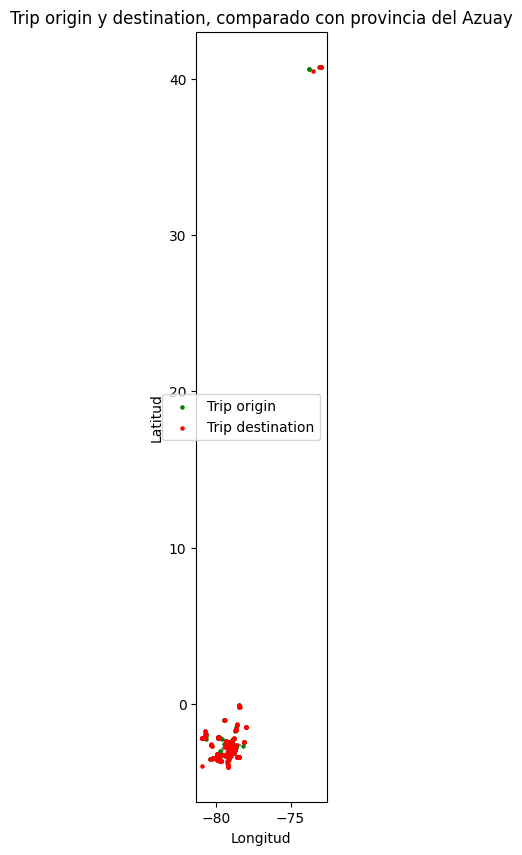

In [ ]:
plot_polygon_points(shapefile_path=azuay_shapefile_path,
                    df_points_list=[
                        DF_Plot_Detail(
                            df_points=df_trips,
                            lon_col='origin_lon',
                            lat_col='origin_lat',
                            mlabel='Trip origin',
                            mcolor='green',
                            msize=5),
                        DF_Plot_Detail(
                            df_points=df_trips,
                            lon_col='destination_lon',
                            lat_col='destination_lat',
                            mlabel='Trip destination',
                            mcolor='red',
                            msize=5)
                        ], 
                    plot_label='Trip origin y destination, comparado con provincia del Azuay',
                    plot_crs=default_crs)

## Filtrar puntos dentro de la provincia del Azuay

- Usando el Dataframe `df_points` haremos un spatial-join con el Shapefile de la provincia del Azuay

Definimos una función para realizar el procesamiento en lotes:

In [6]:
def batched_sjoin_polygon_points(shapefile_path: str,
                                b_size: int, 
                                df_points: pd.DataFrame,
                                points_lon: str,
                                points_lat: str,
                                plot_crs: str,
                                csv_output: str):

    # Cargar shapefile en un GeoDataframe
    gdf_polygon = gpd.read_file(shapefile_path)

    # Establecer el sistema de coordendas
    gdf_polygon = gdf_polygon.to_crs(crs=plot_crs)

    # Tamano de lote y division en lotes
    batch_size = b_size
    total_rows = len(df_points)
    batches = np.array_split(df_points, np.ceil(total_rows/batch_size))

    results = []
    for batch in tqdm(batches):
        # Convertir batch a GeoDataFrame
        geometry = [Point(xy) for xy in zip(batch[points_lon], batch[points_lat])]
        batch_gdf = gpd.GeoDataFrame(batch, geometry=geometry, crs=plot_crs)
        
        # Spatial join
        joined = gpd.sjoin(batch_gdf, gdf_polygon, how='left', predicate='within')
        
        # Marcar points
        batch['in_city'] = ~joined.index_right.isna()
        results.append(batch)

    # Guardar resultados
    result_df = pd.concat(results)
    result_df.to_csv(f'transformed_data/{csv_output}.csv', index=False)
    return result_df

Usamos la función para filtrar los puntos registrados en los viajes realizados dentro del polígono de Azuay

In [ ]:
azuay_points = batched_sjoin_polygon_points(shapefile_path=azuay_shapefile_path,
                                            b_size=10000,
                                            df_points=df_points,
                                            points_lon='longitude',
                                            points_lat='latitude',
                                            plot_crs=default_crs,
                                            csv_output='points_sep2023_in_azuay')

Graficar los puntos dentro de Azuay

/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


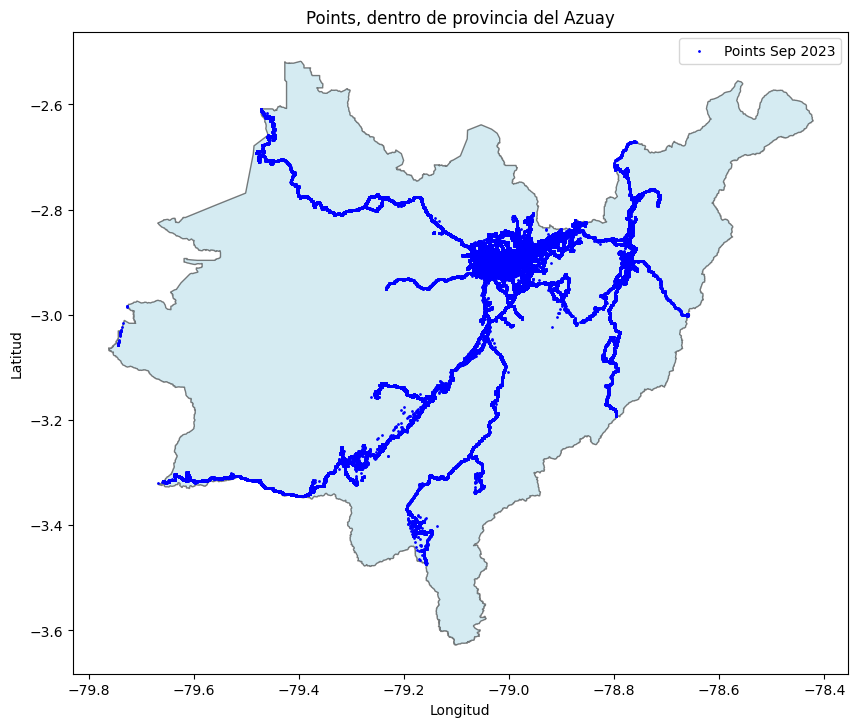

In [ ]:
# Obtener los puntos dentro de la ciudad
# print(azuay_points.dtypes)
azuay_points = azuay_points[azuay_points['in_city'] == True]

# Graficar
plot_polygon_points(shapefile_path=azuay_shapefile_path,
                    df_points_list=[
                        DF_Plot_Detail(
                            df_points=azuay_points,
                            lon_col='longitude',
                            lat_col='latitude',
                            mlabel='Points Sep 2023',
                            mcolor='blue',
                            msize=1),
                        ], 
                    plot_label='Points, dentro de provincia del Azuay',
                    plot_crs=default_crs)


Filtrar trips dentro de Azuay. Primero los puntos de origen y luego los de destino.

In [ ]:
# Trips origin
azuay_points_org = batched_sjoin_polygon_points(shapefile_path=azuay_shapefile_path,
                                            b_size=1000,
                                            df_points=df_trips,
                                            points_lon='origin_lon',
                                            points_lat='origin_lat',
                                            plot_crs=default_crs,
                                            csv_output='azuay_points_sep2023_org')
azuay_points_org = azuay_points_org[azuay_points_org['in_city'] == True]

# Trips destination
azuay_points_dst = batched_sjoin_polygon_points(shapefile_path=azuay_shapefile_path,
                                            b_size=1000,
                                            df_points=df_trips,
                                            points_lon='destination_lon',
                                            points_lat='destination_lat',
                                            plot_crs=default_crs,
                                            csv_output='azuay_points_sep2023_dst')
azuay_points_dst = azuay_points_dst[azuay_points_dst['in_city'] == True]


/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


100%|██████████| 20/20 [00:00<00:00, 48.71it/s]
/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 20/20 [00:00<00:00, 52.54it/s]


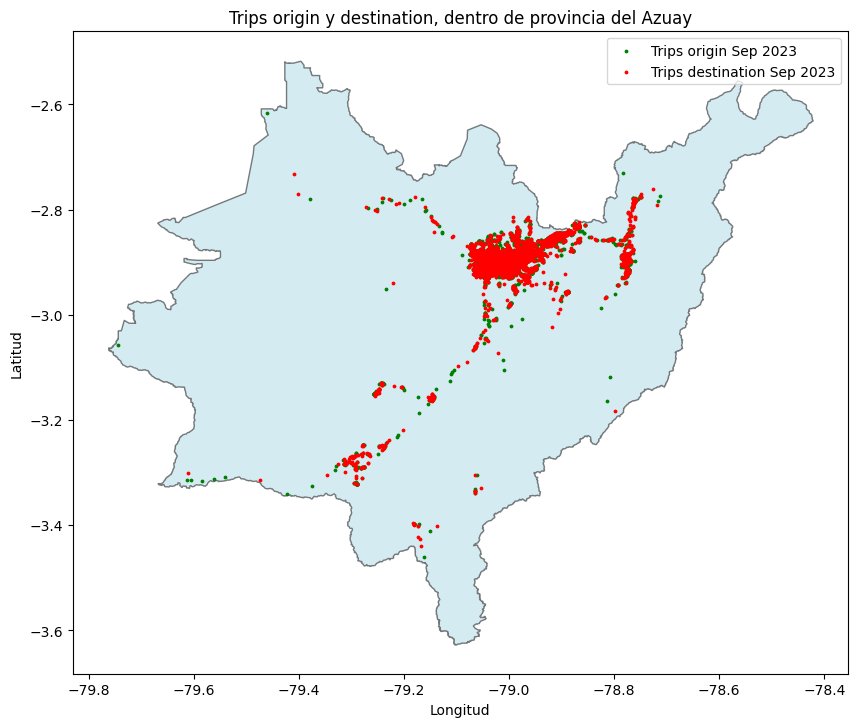

In [ ]:
# Graficar
plot_polygon_points(shapefile_path=azuay_shapefile_path,
                    df_points_list=[
                        DF_Plot_Detail(
                            df_points=azuay_points_org,
                            lon_col='origin_lon',
                            lat_col='origin_lat',
                            mlabel='Trips origin Sep 2023',
                            mcolor='green',
                            msize=3),
                        DF_Plot_Detail(
                            df_points=azuay_points_dst,
                            lon_col='destination_lon',
                            lat_col='destination_lat',
                            mlabel='Trips destination Sep 2023',
                            mcolor='red',
                            msize=3),
                        ], 
                    plot_label='Trips origin y destination, dentro de provincia del Azuay',
                    plot_crs=default_crs)

# Data de movilidad en Ecuador

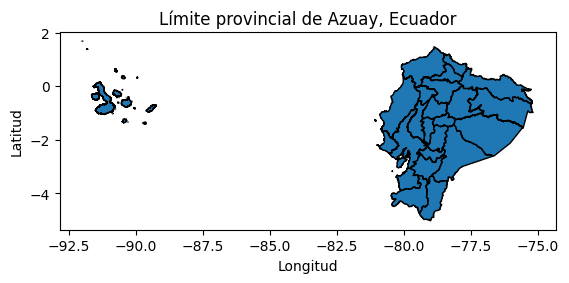

In [7]:
# Leer shapefile en un Geodataframe
gdf_ecuador = gpd.read_file(ecuador_shapefile_path)

# Establecer el sistema de coordendas
gdf_ecuador = gdf_ecuador.to_crs(crs=default_crs)

# Visualizar el shapefile
gdf_ecuador.plot(edgecolor='black')
plt.title('Límite provincial de Azuay, Ecuador')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

## Leer data cruda de movilidad

In [4]:
# Leer CSVs de trips y points
df_trips = pd.read_csv('transformed_data/tripssep2023_epsg4326.csv')
df_points = pd.read_csv('raw_data/puntossept2023.csv')

/tmp/ipykernel_1543/625816747.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points = pd.read_csv('raw_data/puntossept2023.csv')


## Filtrar puntos en Ecuador

In [11]:
ecuador_points = batched_sjoin_polygon_points(shapefile_path=ecuador_shapefile_path,
                                            b_size=10000,
                                            df_points=df_points,
                                            points_lon='longitude',
                                            points_lat='latitude',
                                            plot_crs=default_crs,
                                            csv_output='points_sep2023_in_ecuador')

/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 338/338 [00:39<00:00,  8.52it/s]


In [14]:
ecuador_points = ecuador_points[ecuador_points['in_city'] == True]

## Filtrar trips en Ecuador

In [8]:
# Trips origin
ecuador_points_org = batched_sjoin_polygon_points(shapefile_path=ecuador_shapefile_path,
                                            b_size=1000,
                                            df_points=df_trips,
                                            points_lon='origin_lon',
                                            points_lat='origin_lat',
                                            plot_crs=default_crs,
                                            csv_output='ecuador_points_sep2023_org')
ecuador_points_org = ecuador_points_org[ecuador_points_org['in_city'] == True]

# Trips destination
ecuador_points_dst = batched_sjoin_polygon_points(shapefile_path=ecuador_shapefile_path,
                                            b_size=1000,
                                            df_points=df_trips,
                                            points_lon='destination_lon',
                                            points_lat='destination_lat',
                                            plot_crs=default_crs,
                                            csv_output='ecuador_points_sep2023_dst')
ecuador_points_dst = ecuador_points_dst[ecuador_points_dst['in_city'] == True]


/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 20/20 [00:00<00:00, 20.66it/s]
/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 20/20 [00:00<00:00, 21.28it/s]


## Graficar puntos en Ecuador

/home/dario_ubuntu/Development/patrones_movilidad_met/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


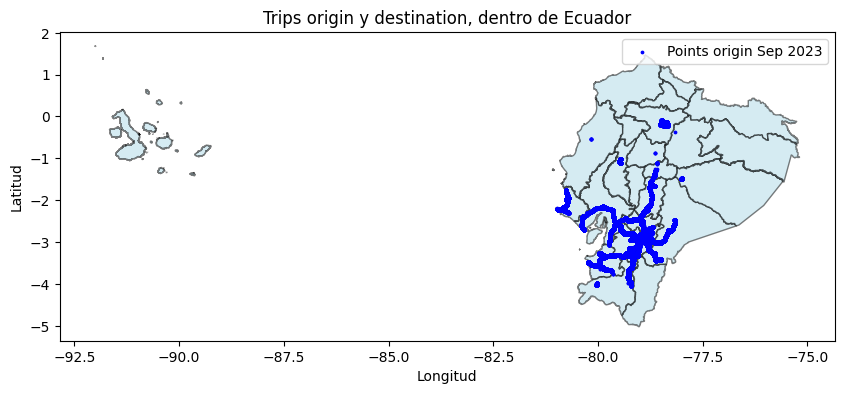

In [ ]:
# Graficar
plot_polygon_points(shapefile_path=ecuador_shapefile_path,
                    df_points_list=[
                        DF_Plot_Detail(
                            df_points=ecuador_points,
                            lon_col='longitude',
                            lat_col='latitude',
                            mlabel='Points Sep 2023',
                            mcolor='blue',
                            msize=3)
                        ], 
                    plot_label='Points dentro de Ecuador',
                    plot_crs=default_crs)

## Graficar trips en Ecuador

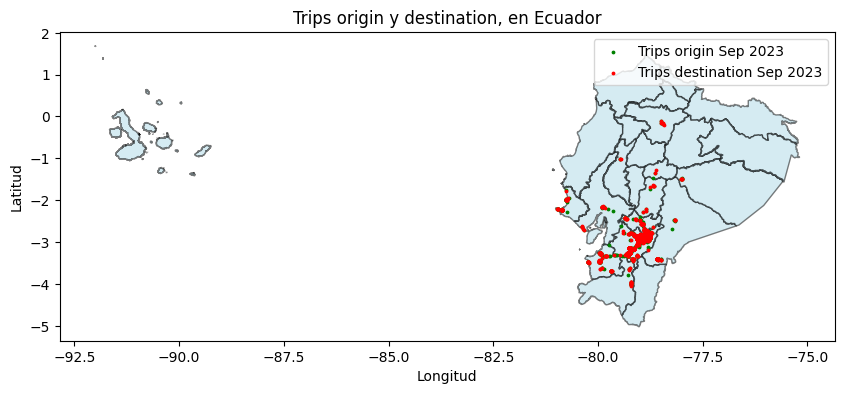

In [9]:
# Graficar
plot_polygon_points(shapefile_path=ecuador_shapefile_path,
                    df_points_list=[
                        DF_Plot_Detail(
                            df_points=ecuador_points_org,
                            lon_col='origin_lon',
                            lat_col='origin_lat',
                            mlabel='Trips origin Sep 2023',
                            mcolor='green',
                            msize=3),
                        DF_Plot_Detail(
                            df_points=ecuador_points_dst,
                            lon_col='destination_lon',
                            lat_col='destination_lat',
                            mlabel='Trips destination Sep 2023',
                            mcolor='red',
                            msize=3),
                        ], 
                    plot_label='Trips origin y destination, en Ecuador',
                    plot_crs=default_crs)